In [ ]:
!pip install Cmake

In [ ]:
!pip install wheel

In [ ]:
!pip install attrdict3

In [ ]:
!pip install bintrees

In [ ]:
!pip install scikit-learn-extra

In [ ]:
import bintrees

In [31]:
from copy import copy
from matplotlib.pyplot import figure
from scipy.optimize import linear_sum_assignment
from scipy.special import binom
from sklearn.cluster import KMeans
from sklearn.covariance import MinCovDet
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sympy.combinatorics import Permutation
from tqdm.notebook import tqdm
import itertools
import heapq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import time
import warnings

In [32]:
warnings.filterwarnings('ignore')

In [33]:
def dist(a, b):
    return np.sum((a - b)**2)

In [34]:
def abcd(Y_1, Y_2):
    a = np.sum(np.equal.outer(Y_1, Y_1) & np.equal.outer(Y_2, Y_2))
    b = np.sum(np.equal.outer(Y_1, Y_1) & ~np.equal.outer(Y_2, Y_2))
    c = np.sum(~np.equal.outer(Y_1, Y_1) & np.equal.outer(Y_2, Y_2))
    d = np.sum(~np.equal.outer(Y_1, Y_1) & ~np.equal.outer(Y_2, Y_2))
    return a, b, c, d

In [35]:
def RI(Y_1, Y_2):
    a, b, c, d = abcd(Y_1, Y_2)
    return (a + b) / (a + b + c + d)

def FM(Y_1, Y_2):
    a, b, c, d = abcd(Y_1, Y_2)
    t = np.sqrt(a / (a + b) * a / (a + c))
    return t

def J(Y_1, Y_2):
    a, b, c, d = abcd(Y_1, Y_2)
    return a / (a + b + c)

def NI(Y_1, Y_2):
    a, b, c, d = abcd(Y_1, Y_2)
    return (d - c) / np.sqrt(d + c)

def SSI(Y_1, Y_2):
    a, b, c, d = abcd(Y_1, Y_2)
    return a/(a + 2 * (b + c))

def CDI(Y_1, Y_2):
    a, b, c, d = abcd(Y_1, Y_2)
    return 2 * a /(2 * a + b + c)

In [36]:
def get_A(k, N, number):
    n_min = N // (number * k)
    random_values = np.random.rand(k - 1)
    random_values = np.append(random_values, 0)
    random_values = np.append(random_values, 1)
    random_values = np.sort(random_values)
    shifts = []
    for i in range(1, k + 1):
        shifts.append(random_values[i] - random_values[i - 1])
    return [round(n_min + (N - k * n_min) * shifts[i]) for i in range(k)]

In [37]:
A = get_A(7, 1000, 10)

In [38]:
class Synthetic_data_generator:

    def __init__(self, Ns, V, alpha):
        self.K = len(Ns)
        self.N = np.sum(Ns)
        self.Ns = Ns
        self.V = V
        self.alpha = alpha
        assert 0 < self.alpha < 1

    def find_centroids(self):
        self.centroids = np.random.uniform(self.alpha - 1, 1 - self.alpha, (self.K, self.V))

    def add_elem(self, i, elem, matrix):
        if i == 0:
            return elem
        return np.append(matrix, elem, axis=0)

    def find_clusters(self):
        matrix = None
        self.find_centroids()
        for i in range(self.K):
            s_k = np.random.uniform(0.05, 0.1, self.V)
            centroids = np.repeat(np.array([self.centroids[i]]), self.Ns[i], axis=0)
            elem = np.random.normal(0, s_k, (self.Ns[i], self.V)) + centroids
            matrix = self.add_elem(i, elem, matrix)
        return matrix

In [39]:
my_class = Synthetic_data_generator(A, 11, 0.25)

In [40]:
Data = my_class.find_clusters()

In [41]:
def get_data(k, N, d, eps):
    A = get_A(k, N, 10)
    my_class = Synthetic_data_generator(A, d, eps)
    clusters = my_class.find_clusters()
    centers = my_class.centroids
    plt.figure(0)
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    return A, clusters, centers

In [42]:
class SSE:

    def __init__(self, X, centroids):
        self.X = X
        self.centroids = centroids

    def eucl(self, a, b):
        return np.sum((a - b)**2)

    def find_SSE(self):
        return np.sum([min(map(lambda y : self.eucl(self.X[i], y), self.centroids)) for i in range(len(self.X))])

In [ ]:
class LOG_Means:

    def __init__(self, X, data, k_low, k_high, eps):
        self.X = X
        self.data = data
        self.k_started_low = k_low
        self.k_started_high = k_high
        self.k_low = k_low
        self.k_high = k_high
        self.eps = eps

    def k_means_sse(self, my_k):
        KMs = KMeans(n_clusters=my_k, random_state=0).fit(self.X)
        centroids = KMs.cluster_centers_
        my_sse = SSE(self.X, centroids).find_SSE()
        return my_sse

    def make_insert(self, k, K):
        my_SSE = self.k_means_sse(k)
        K.insert(k, my_SSE)
        return my_SSE, K

    def find_start(self):
        self.k_low = self.k_low - 1
        K, M, H = bintrees.FastRBTree(), {}, []
        SSE_low, K = self.make_insert(self.k_low, K)
        SSE_high, K = self.make_insert(self.k_high, K)
        return self.k_low, K, M, H, SSE_low, SSE_high

    def adjacent(self, a, b):
        return abs(a - b) == 1

    def insert_ratio(self, M, k, SSE_1, SSE_2, H=[], flag=False):
        ratio = SSE_1 / SSE_2
        M[k] = ratio
        if flag:
            heapq.heappush(H, (ratio, k))
        return ratio, M, H

    def make_iteraion(self, K, M, H, SSE_low, SSE_high):
        k_mid = (self.k_high + self.k_low) // 2
        SSE_mid, K = self.make_insert(k_mid, K)
        ratio_left, M, H = self.insert_ratio(M, k_mid, SSE_low, SSE_mid, H, True)
        ratio_right, M, H = self.insert_ratio(M, self.k_high, SSE_mid, SSE_high, H, True)
        self.k_high = heapq.nlargest(1, H)[0][1]
        self.k_low, SSE_low = K.prev_item(self.k_high)
        SSE_high = K.get(self.k_high)
        return K, M, H, SSE_low, SSE_high

    def find_k_bend(self, M):
        highest_ratio = -float('inf')
        k_bend = self.k_low
        for k in range(self.k_low, self.k_high + 1):
            if k in M and M[k] > highest_ratio:
                highest_ratio = M[k]
                k_bend = k
        return k_bend

    def K_M_change(self, K, M):
        for k in range(self.k_low, self.k_high + 1):
            SSE_prev = K.floor_item(k)[1]
            if K.__contains__(k):
                SSE_k = K.get(k)
            else:
                SSE_k, K = self.make_insert(k, K)
            ratio_k, M, _ = self.insert_ratio(M, k, SSE_prev, SSE_k)
        return M

    def find(self):
        self.k_low, K, M, H, SSE_low, SSE_high = self.find_start()
        while(not self.adjacent(self.k_low, self.k_high)):
            K, M, H, SSE_low, SSE_high = self.make_iteraion(K, M, H, SSE_low, SSE_high)
        if self.eps > 0:
            k_bend = self.find_k_bend(M)
            self.k_low, self.k_high = max(self.k_started_low, k_bend - int(self.eps / 2)),
            min(self.k_started_high, k_bend + int(self.eps / 2))
            M = self.K_M_change(K, M)
        k_bend = self.find_k_bend(M)
        return k_bend, KMeans(n_clusters=k_bend, random_state=0).fit(self.X).labels_

In [ ]:
class SecondAlg:

    def __init__(self, X, distance):
        self.X = X
        self.n = len(self.X)
        self.distance = distance

    def find_distance_matrix(self):
        Y = np.array([[0 for i in range(len(self.X))] for j in range(len(self.X))])
        for i, elem1 in enumerate(self.X):
            for j, elem2 in enumerate(self.X):
                Y[i][j] = self.distance(elem1, elem2)
        etta = np.sum(Y) / (2 * self.n * (self.n - 1))
        for i in range(len(self.X)):
            Y[i][i] = etta
        self.dst_matr = Y
        self.k = len(self.dst_matr)

    def Hungarian(self):
        permutation = [0 for i in range(len(self.dst_matr))]
        row, columns = linear_sum_assignment(self.dst_matr)
        for i, elem in enumerate(row):
            permutation[elem] = columns[i]
        self.permutation = permutation

    def find_cycles(self):
        p = Permutation(self.permutation)
        self.clusters = p.full_cyclic_form
        self.k_hatch = len(self.clusters)

    def inter_dist(self, cluster_1, cluster_2):
        if len(cluster_1) == 0 or len(cluster_2) == 0:
            return 0
        distance = 0
        for i in range(len(cluster_1)):
            for j in range(len(cluster_2)):
                distance += self.dst_matr[cluster_1[i]][cluster_2[j]]
        distance /= (len(cluster_1) * len(cluster_2))
        return distance


    def get_matrix_for_cycl(self):
        M = [[0 for i in range(self.k_hatch)] for j in range(self.k_hatch)]
        for i in range(self.k_hatch):
            for j in range(self.k_hatch):
                M[i][j] = self.inter_dist(self.clusters[i], self.clusters[j])
        self.dst_matr = np.array(M)

    def find(self):
        self.find_distance_matrix()
        while True:
            self.Hungarian()
            self.find_cycles()
            self.get_matrix_for_cycl()
            if self.k == self.k_hatch:
                return self.k
            self.k = self.k_hatch
        return self.k


In [ ]:
class Criterion:

    def __init__(self, X):
        self.X = X
        self.n = len(self.X)
        self.k = 1
        self.VI = [-1]
        self.VI.append(0)

    def depths(self, V):
        a = MinCovDet(random_state=0).fit(V).dist_
        return 1 / (1 + a)

    def find_within(self, j, left, right):
        my_D = self.depths(self.X[left:right])
        my_u = np.max(my_D)
        summa = np.mean(my_u - my_D)
        if j == 0:
            self.D = []
        self.D.append(my_D)
        return my_u, summa

    def find_between(self, j, left, right):
        return np.min(np.delete(np.mean(np.add.outer(np.array(self.u), -self.D[j]), axis=1), j))

    def find_left_right(self, j, Range):
        if j + 1 != self.k:
            left = j * Range
            right = left + Range
        else:
            left = j * Range
            right = self.n
        return left, right

    def find_u_wd(self):
        for j in range(self.k):
            left, right = self.find_left_right(j, self.Range)
            self.u[j], self.wd[j] = self.find_within(j, left, right)

    def find_bd(self):
        for j in range(self.k):
            left, right = self.find_left_right(j, self.Range)
            self.bd[j] = self.find_between(j, left, right)

    def find(self):
        while self.VI[self.k] >= self.VI[self.k - 1]:
            self.k += 1
            self.Range = self.n // self.k
            self.wd, self.bd, self.u = [0 for i in range(self.k)], [0 for i in range(self.k)], [0 for i in range(self.k)]
            self.find_u_wd(), self.find_bd()
            self.dd = np.array(self.wd) - np.array(self.bd)
            self.VI.append(np.mean(self.dd))
        res_k, index, cluster_labels = self.k - 1, 0, [0 for i in range(self.n)]
        for i in range(self.n):
            cluster_labels[i] = index
            if i % self.Range == 0:
                index += 1
        return index, cluster_labels

In [ ]:
def get_uniform(my_low, my_high, my_size):
    return np.random.uniform(low=my_low, high=my_high, size=my_size)

In [ ]:
class CLEST:

    def __init__(self, X, B, B_0, K, P, CL, p_max, d_min, generate_data, index):
        self.X = X
        self.B = B
        self.B_0 = B_0
        self.K = K
        self.P = P
        self.CL = CL
        self.index = index
        self.generate_data = generate_data
        self.p_max = p_max
        self.d_min = d_min

    def get_median(self, data, k):
        ex_inds = np.array([0.0 for i in range(self.B)])
        for i in range(self.B):
            X_1, X_2 = train_test_split(data, train_size=2/3)
            Y_1 = self.P(n_clusters=k, method='pam').fit(X_1).labels_
            self.CL.fit(X_1, Y_1)
            Y_2_class = self.CL.predict(X_2)
            Y_2_clust = self.P(k, method='pam').fit(X_2).labels_
            ex_inds[i] = self.index(Y_2_class, Y_2_clust)
        return np.median(ex_inds)


    def find_for_cluster(self, k):
        t_k = self.get_median(self.X, k)
        t_ks = np.array([0.0 for i in range(self.B_0)])
        for i in range(self.B_0):
            func, my_low, my_high, my_size, my_k = self.generate_data
            X_i = func(my_low, my_high, my_size)
            t_ks[i] = self.get_median(X_i, my_k)
        t_k0 = np.average(t_ks)
        p_k = np.average(t_ks >= t_k)
        d_k = t_k - t_k0
        return p_k, d_k


    def find(self):
        p, d = {}, {}
        for k in range(2, self.K + 1):
            p[k], d[k] = self.find_for_cluster(k)
        res_k, d_max = None, -float('inf')
        for k in range(2, self.K + 1):
            if p[k] <= self.p_max and d[k] >= self.d_min:
                if d[k] >= d_max:
                    d_max, res_k = d[k], k
        if type(res_k) == type(None):
            return 1
        return res_k

In [ ]:
class U_K_Means:

    def __init__(self, X, eps):
        self.X = X
        self.eps = eps
        self.n = len(self.X)
        assert self.n > 0
        self.d = len(self.X[0])
        self.c = [self.n]
        self.alpha = [[1/self.n for k in range(self.c[0])]]
        self.a = [[self.X[k] for k in range(self.c[0])]]
        self.gamma = [1]
        self.betta = [1]
        self.z = [None]
        self.t = 0

    def find_etta(self):
        if self.t == 0:
            return 1
        return min(1, 1/self.t**(int(self.d / 2 - 1)))

    def eucl(self,x, y):
        return np.sum((x - y)**2)

    def z_expression(self, i, k):
        return self.eucl(self.X[i], self.a[self.t][k]) - self.gamma[self.t] * np.log(self.alpha[self.t][k])

    def find_z(self):
        z = [[0 for k in range(self.c[self.t])] for i in range(self.n)]
        for i in range(self.n):
            minimum = np.float('inf')
            for k in range(self.c[self.t]):
                cur_exp = self.z_expression(i, k)
                if cur_exp < minimum:
                    minimum = cur_exp
            for k in range(self.c[self.t]):
                cur_exp = self.z_expression(i, k)
                if cur_exp == minimum:
                    z[i][k] = 1
        return z

    def find_gamma(self):
        return np.exp(-self.c[self.t] / 250)

    def find_useful_summa(self):
        useful_summa = 0
        for s in range(self.c[self.t]):
            useful_summa += self.alpha[self.t][s] * np.log(self.alpha[self.t][s])
        return useful_summa

    def find_alpha(self):
        alpha = [0 for k in range(self.c[self.t])]
        useful_summa = self.find_useful_summa()
        for k in range(self.c[self.t]):
            for i in range(self.n):
                alpha[k] += self.z[self.t + 1][i][k] / self.n
            alpha[k] += self.betta[self.t] / self.gamma[self.t] * self.alpha[self.t][k] * (np.log(self.alpha[self.t][k]) - useful_summa)
        return alpha


    def find_left(self):
        alpha_t = self.alpha[self.t]
        alpha_t1 = self.alpha[self.t + 1]
        left = 0
        for k in range(self.c[self.t]):
            left += np.exp(-self.etta * self.n * abs(alpha_t1[k] - alpha_t[k]))
        left /= self.c[self.t]
        return left


    def find_numerator(self):
        maximum = -np.float('inf')
        for k in range(self.c[self.t]):
            summa = 0
            for i in range(self.n):
                summa += self.z[self.t + 1][i][k]
            summa /= self.n
            if summa >= maximum:
                maximum = summa
        return 1 - maximum


    def find_denominator(self):
        maximum = -np.float('inf')
        for k in range(self.c[self.t]):
            summa = 0
            for k2 in range(self.c[self.t]):
                summa += np.log(self.alpha[self.t][k2])
            summa *= self.alpha[self.t][k]
            if summa >= maximum:
                maximum = summa
        return -maximum


    def find_right(self):
        return self.find_numerator() / self.find_denominator()


    def find_betta(self):
        left = self.find_left()
        right = self.find_right()
        return min(left, right)


    def find_c(self):
        new_answer = 0
        for k in range(self.c[self.t]):
            if self.alpha[self.t + 1][k] > 1/self.n:
                new_answer += 1
        return new_answer

    def update_alpha(self, new_c):
        new_alpha = [0 for k in range(new_c)]
        new_k = 0
        for k in range(self.c[self.t]):
            if self.alpha[self.t + 1][k] > 1/self.n:
                new_alpha[new_k] = self.alpha[self.t + 1][k]
                new_k += 1
        return new_alpha


    def update_z(self, new_c):
        new_z = [[0 for k in range(new_c)] for i in range(self.n)]
        for i in range(self.n):
            new_k = 0
            for k in range(self.c[self.t]):
                if self.alpha[self.t + 1][k] > 1/self.n:
                    new_z[i][new_k] = self.z[self.t + 1][i][k]
                    new_k += 1
        return new_z



    def update(self):
        new_c = self.c[self.t + 1]
        new_alpha = self.update_alpha(new_c)
        new_z = self.update_z(new_c)
        summa1 = np.sum(new_alpha)
        for k in range(new_c):
            new_alpha[k] /= summa1
        for i in range(self.n):
            summa2 = np.sum(new_z[i])
            for k in range(new_c):
                new_z[i][k] /= summa2
        return new_alpha, new_z


    def find_a(self):
        a = []
        for k in range(self.c[self.t + 1]):
            summa1 = 0
            summa2 = 0
            for i in range(self.n):
                summa1 += self.z[self.t + 1][i][k] * self.X[i]
                summa2 += self.z[self.t + 1][i][k]
            a.append(list(summa1/summa2))
        return a


    def find_change(self):
        res_dist = -np.float('inf')
        for k in range(self.c[self.t]):
            cur_dist = self.eucl(self.a[self.t + 1][k], self.a[self.t][k])
            if cur_dist > res_dist:
                res_dist = cur_dist
        return res_dist


    def find(self):
        while True:
            self.etta = self.find_etta()
            self.z.append(self.find_z())
            self.gamma.append(self.find_gamma())
            self.alpha.append(self.find_alpha())
            self.betta.append(self.find_betta())
            self.c.append(self.find_c())
            new_alpha, new_z = self.update()
            self.alpha[self.t + 1] = new_alpha
            self.z[self.t + 1] = new_z
            if self.t >= 60:
                if self.c[self.t - 60] - self.c[self.t] == 0:
                    self.betta[self.t + 1] = 0
            self.a.append(self.find_a())
            if self.c[self.t] == self.c[self.t + 1]:
                if self.find_change() < self.eps:
                    break
            self.t += 1
        return self.c[-1], self.a[-1], self.z[-1]

In [ ]:
st1 = time.time()
k1 = LOG_Means(Data, pd.DataFrame(Data), 2, 21, 0).find()
end1 = time.time()
my_time1 = end1 - st1

In [ ]:
my_time1

3.2791433334350586

In [ ]:
st2 = time.time()
k2 = SecondAlg(Data, dist).find()
end2 = time.time()
my_time2 = end2 - st2

In [ ]:
my_time2

13.360825300216675

In [ ]:
st3 = time.time()
k3 = Criterion(Data).find()
end3 = time.time()
my_time3 = end3 - st3

In [ ]:
my_time3

6.003720998764038

In [ ]:
st4 = time.time()
k4 = CLEST(Data, 20, 20, 2 * 7, KMedoids, LinearDiscriminantAnalysis(solver='lsqr', shrinkage=1), 0.05, 0.05, (get_uniform, 10, 20, (40, 10), 3), FM).find()
end4 = time.time()
my_time4 = end4 - st4

In [ ]:
my_time4

180.94302344322205

In [ ]:
st5 = time.time()
k5 = U_K_Means(Data, 0.001).find()
end5 = time.time()
my_time5 = end5 - st5

In [ ]:
my_time5

25.16864275932312

In [ ]:
class ARI:

    def __init__(self, X, A, B):
        self.X = X
        self.N = len(self.X)
        self.A = A
        self.B = B
        self.K_A = len(self.A)
        self.K_B = len(self.B)
        self.N_2 = binom(self.N, 2)

    def inter(self, A, B, k, m):
        return len(set(A[k]).intersection(set(B[m])))

    def find_big_summa(self):
        summa = 0
        for (k, m) in itertools.product(range(self.K_A), range(self.K_B)):
            summa += binom(self.inter(self.A, self.B, k, m), 2)
        return summa

    def find_binom_summa(self, K, array):
        result = 0
        for k in range(K):
            result += binom(len(array[k]), 2)
        return result

    def find_prod(self):
        return self.find_binom_summa(self.K_A, self.A) * self.find_binom_summa(self.K_B, self.B)

    def find_summ(self):
        return self.find_binom_summa(self.K_A, self.A) + self.find_binom_summa(self.K_B, self.B)

    def find(self):
        self.summ1 = self.N_2 * self.find_big_summa()
        self.summ2 = 1/2 * self.N_2 * self.find_prod()
        self.summ3 = self.find_summ()
        if self.summ1 == self.summ3:
            return 1.0
        if self.summ3 == self.summ2:
            return np.sign(self.summ1 - self.summ2) * np.float('inf')
        return (self.summ1 - self.summ2) / (self.summ3 - self.summ2)


In [ ]:
def get_A(k, N, number):
    n_min = N // (number * k)
    random_values = np.random.rand(k - 1)
    random_values = np.append(random_values, 0)
    random_values = np.append(random_values, 1)
    random_values = np.sort(random_values)
    shifts = []
    for i in range(1, k + 1):
        shifts.append(random_values[i] - random_values[i - 1])
    return [round(n_min + (N - k * n_min) * shifts[i]) for i in range(k)]

In [ ]:
def get_data(k, N, d, eps):
    A = get_A(k, N, 10)
    my_class = Synthetic_data_generator(A, d, eps)
    clusters = my_class.find_clusters()
    centers = my_class.centroids
    plt.figure(0)
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    return A, clusters, centers

In [ ]:
def draw2DData(A, Data, centers):
    label = []
    for i in range(len(A)):
        label.extend([i for j in range(A[i])])
    u_labels = np.unique(label)
    df = pd.DataFrame(Data)
    plt.figure(1)
    for i in u_labels:
        plt.scatter(df[label == i][0] , df[label == i][1] , label = i)
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    plt.legend()
    plt.show()

In [ ]:
def draw_data(k, N, d, eps):
    draw2DData(*get_data(k, N, d, eps))

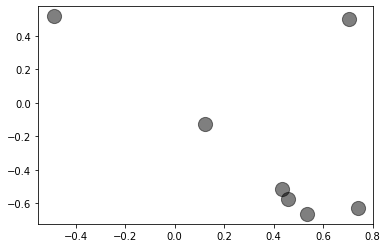

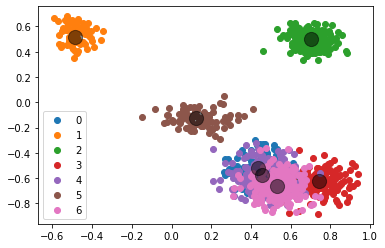

In [ ]:
draw_data(7, 1000, 2, 0.25)

In [ ]:
def make_data(cardinality):
    ks = [7, 15]
    Ns = [1000]
    Epses = [0.75, 0.5, 0.25]
    ds = [11]
    get_datas = []
    for k in ks:
        for eps in Epses:
            for i in range(cardinality):
                get_datas.append(get_data(k, Ns[0], ds[0], eps))
    return get_datas

In [ ]:
def difference(k, k_est):
    if k == 0:
        return abs(k - k_est)
    return abs(k - k_est) / k

In [ ]:
def get_labels(A):
    k, n, labels, index = len(A), np.sum(A), [], 0
    for i in range(len(A)):
        cur_labels = []
        for j in range(A[i]):
            cur_labels.append(index)
            index += 1
        labels.append(cur_labels)
    return labels

In [ ]:
def get_new_labels(old_labels):
    n, k, new_labels = len(old_labels), len(set(old_labels)), [[] for i in range(k)]
    for i in range(n):
        new_labels[old_labels[i]].append(i)
    return new_labels

In [ ]:
def get_labels_UKMeans(k_est, z):
    new_labels = [list(np.where(np.array(z)[:,i])[0]) for i in range(k_est)]
    return new_labels

In [ ]:
def make_LOG_Means(cardinality, count, get_datas):
    difs = [[0 for i in range(cardinality)] for j in range(count)]
    aris = [[0 for i in range(cardinality)] for j in range(count)]
    meandifs, stddifs, meanaris, stdaris = [], [], [], []
    for i in range(count):
        for j in range(cardinality):
            A, Matr = get_datas[i * count + j]
            k_est, clusters = LOG_Means(Matr, pd.DataFrame(Matr), 2, 5 * len(A), 0).find()
            difs[i][j] = difference(len(A), k_est)
            aris[i][j] = ARI(Matr, get_labels(A), get_new_labels(clusters)).find()
        meandifs.append(np.mean(difs[i]))
        stddifs.append(np.std(difs[i]))
        meanaris.append(np.mean(aris[i]))
        stdaris.append(np.std(aris[i]))
    return meandifs, stddifs, meanaris, stdaris

In [ ]:
def make_Second_Alg(cardinality, count, get_datas):
    difs = [[0 for i in range(cardinality)] for j in range(count)]
    meandifs, stddifs = [], []
    for i in range(count):
        for j in range(cardinality):
            A, Matr = get_datas[i * count + j]
            k_est = SecondAlg(Matr, dist).find()
            difs[i][j] = difference(len(A), k_est)
        meandifs.append(np.mean(difs[i]))
        stddifs.append(np.std(difs[i]))
    return meandifs, stddifs

In [ ]:
def make_Criterion(cardinality, count, get_datas):
    difs = [[0 for i in range(cardinality)] for j in range(count)]
    aris = [[0 for i in range(cardinality)] for j in range(count)]
    meandifs, stddifs, meanaris, stdaris = [], [], [], []
    for i in range(count):
        for j in range(cardinality):
            A, Matr = get_datas[i * count + j]
            k_est, clusters = Criterion(Matr).find()
            difs[i][j] = difference(len(A), k_est)
            aris[i][j] = ARI(Matr, get_labels(A), get_new_labels(clusters)).find()
        meandifs.append(np.mean(difs[i]))
        stddifs.append(np.std(difs[i]))
        meanaris.append(np.mean(aris[i]))
        stdaris.append(np.std(aris[i]))
    return meandifs, stddifs, meanaris, stdaris

In [ ]:
def make_CLEST(cardinality, count, get_datas):
    difs = [[0 for i in range(cardinality)] for j in range(count)]
    meandifs, stddifs, last_i = [], [], 0
    for (i, j) in tqdm(itertools.product(range(count), range(cardinality))):
        A, Matr = get_datas[i * count + j]
        k_est = CLEST(Matr, 20, 20, 2 * len(A), KMedoids, LinearDiscriminantAnalysis(solver='lsqr', shrinkage=1), 0.05, 0.05, (get_uniform, 10, 20, (40, 10), 3), FM).find()
        difs[i][j] = difference(len(A), k_est)
        if last_i != i:
            meandifs.append(np.mean(difs[last_i]))
            stddifs.append(np.std(difs[last_i]))
            last_i = i
    meandifs.append(np.mean(difs[count - 1]))
    stddifs.append(np.std(difs[count - 1]))
    return meandifs, stddifs

In [ ]:
def make_UKMeans(cardinality, count, get_datas):
    difs = [[0 for i in range(cardinality)] for j in range(count)]
    aris = [[0 for i in range(cardinality)] for j in range(count)]
    meandifs, stddifs, meanaris, stdaris, last_i  = [], [], [], [], 0
    for (i, j) in tqdm(itertools.product(range(count), range(cardinality))):
        A, Matr = get_datas[i * count + j]
        k_est, a, z = U_K_Means(Matr, 0.001).find()
        difs[i][j] = difference(len(A), k_est)
        aris[i][j] = ARI(Matr, get_labels(A), get_labels_UKMeans(k_est, z)).find()
        if last_i != i:
            meandifs.append(np.mean(difs[last_i]))
            stddifs.append(np.std(difs[last_i]))
            meanaris.append(np.mean(aris[last_i]))
            stdaris.append(np.std(aris[last_i]))
            last_i = i
    meandifs.append(np.mean(difs[count - 1]))
    stddifs.append(np.std(difs[count - 1]))
    meanaris.append(np.mean(aris[count - 1]))
    stdaris.append(np.std(aris[count - 1]))
    return meandifs, stddifs, meanaris, stdaris

In [ ]:
gt_dts = make_data(10)

In [ ]:
meandifs1, stddifs1, meanaris1, stdaris1 = make_LOG_Means(10, 6, gt_dts)
print(meandifs1, stddifs1, meanaris1, stdaris1)

In [ ]:
meandifs2, stddifs2 = make_Second_Alg(10, 6, gt_dts)
print(meandifs2, stddifs2)

In [ ]:
meandifs3, stddifs3, meanaris3, stdaris3 = make_Criterion(10, 6, gt_dts)
print(meandifs3, stddifs3, meanaris1, stdaris1)

In [ ]:
meandifs4, stddifs4 = make_CLEST(10, 6, gt_dts)
print(meandifs4, stddifs4)

0it [00:00, ?it/s]

[0.17142857142857143, 0.12857142857142856, 0.22857142857142856, 0.3571428571428571, 0.3380952380952381, 0.4] [0.10690449676496974, 0.1622545241657221, 0.29416086117105716, 0.3080551236121118, 0.2383712685665043, 0.1520233900132184]


In [ ]:
meandifs5, stddifs5, meanaris5, stdaris5 = make_UKMeans(10, 6, gt_dts)
print(meandifs5, stddifs5, meanaris5, stdaris5)

0it [00:00, ?it/s]

[141.82857142857142, 141.82857142857145, 141.84285714285713, 141.90000000000003, 111.41809523809525, 65.64666666666666] [0.08571428571428329, 0.08571428571428329, 0.09999999999999716, 0.09147320339189524, 37.39675066826285, 0.04268749491622278] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
